# Compare CellCommander annotations associated with publication objects
**Author**: Adam Klie (last modified: 10/08/2023)<br>
***
**Description**: This script looks at whether the samples as processed by me look like those processed from the publication

# Set-up

In [1]:
# Python packages
import os
import seaborn as sns
import anndata as ad
import glob
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_venn import venn2

In [31]:
# List h5ads to integrate
results_paths = [
    #"/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/26Oct23/cellcommander",
    #"/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/25Oct23/snapatac2/cellcommander_recipe"
    "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe"
]

In [33]:
# List h5ads to integrate
h5ad_paths = []
for results_path in results_paths:
    #h5ad_paths += sorted(glob.glob(os.path.join(results_path, "*", "reduce_dimensions", "*.h5ad"))) # cellcommander
    h5ad_paths += sorted(glob.glob(os.path.join(results_path, "*", "clustered.h5ad"))) # snapatac2
len(h5ad_paths), h5ad_paths

(5,
 ['/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM129/clustered.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM157/clustered.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM166/clustered.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM168/clustered.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM290/clustered.h5ad'])

# Concatenate all the samples

In [34]:
# Read in samples
adata_list = []
samples = []
for h5ad_path in h5ad_paths:
    sample = h5ad_path.split("/")[-2]  # snapatac2
    #sample = h5ad_path.split("/")[-3]  # cellcommander
    adata = sc.read_h5ad(h5ad_path)
    adata.obs.index = sample + "_" + adata.obs.index
    adata.obs.index = adata.obs.index.str.replace("-1", "")  # Needed this for this case
    adata_cp = sc.AnnData(adata.X.copy(), obs=adata.obs.copy(), var=adata.var.copy())
    adata_list.append(adata_cp)
    samples.append(sample)
samples

['MM129', 'MM157', 'MM166', 'MM168', 'MM290']

In [35]:
# Concat samples
adata_concat = ad.concat(adata_list, label="sample", keys=samples)
adata_concat.obs["sample"].value_counts()

MM157    33835
MM129    18508
MM166     9101
MM290     7150
MM168     6847
Name: sample, dtype: int64

# Create annotations for previous
For now, I'm manually labeling the clusters using the UMAP in the publication.

In [36]:
# Load in previous adata
adata_prev = sc.read_h5ad("/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/04Jul23/GSE202498_final_cluster.h5ad")
adata_prev

AnnData object with n_obs × n_vars = 65255 × 54493
    obs: 'batch', 'donor', 'duplicated_reads', 'frac_duplicated_reads', 'frac_mito_reads', 'frac_promoters_used', 'frac_reads_in_peaks', 'frac_reads_in_promoters', 'log10_n_counts', 'log10_n_peaks', 'log10_usable_counts', 'log_usable_counts', 'n_counts', 'n_peaks', 'norm_log_counts', 'reads_in_peaks', 'reads_in_promoters', 'total_sequenced_reads', 'tss_used', 'unique_mito_reads', 'unique_usable_reads', 'leiden'
    uns: 'leiden', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

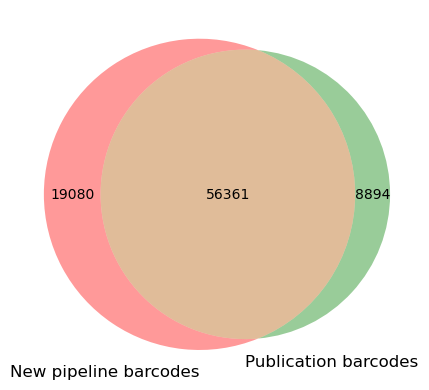

In [37]:
# Create a venn diagram of the barcode overlap between adata.obs.index and merged_df["barcode"]
venn2([set(adata_concat.obs.index), set(adata_prev.obs_names)], set_labels=["New pipeline barcodes", "Publication barcodes"])
plt.show()

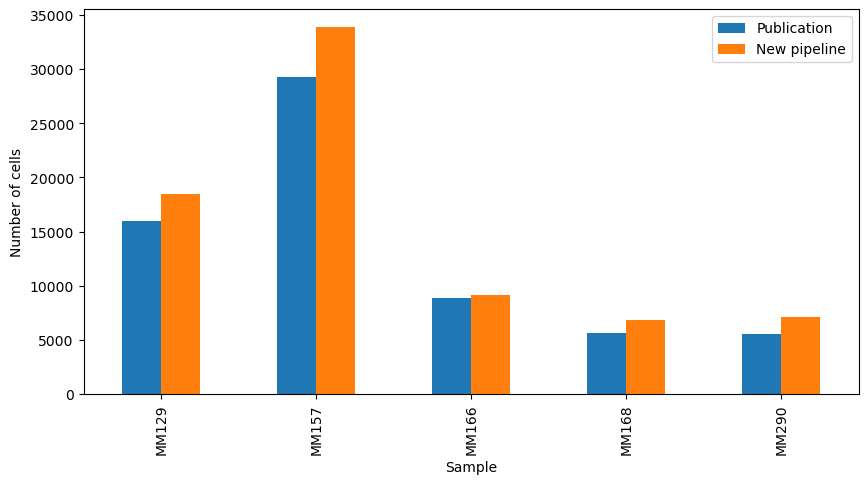

In [38]:
# Compare the numbers of each sample in the new pipeline vs the publication using one barplot
fig, ax = plt.subplots(figsize=(10, 5))
prev_counts = adata_prev.obs["donor"].value_counts()
new_counts = adata_concat.obs["sample"].value_counts()
plot_data = pd.DataFrame({"Publication": prev_counts, "New pipeline": new_counts}).fillna(0)
plot_data.plot.bar(ax=ax)
ax.set_ylabel("Number of cells")
ax.set_xlabel("Sample")
plt.show()

# Back out annotations

In [39]:
# Manually define clusters
cellid_dict = {
    "0": "SC.alpha",
    "1": "SC.EC",
    "2": "PP1",
    "3": "SC.beta",
    "4": "ENP1",
    "5": "ENP3",
    "6": "ENP2",
    "7": "PP2",
    "8": "ENP.alpha",
    "9": "SC.delta",
}

In [40]:
# Add the cellid column
adata_prev.obs["cellid"] = adata_prev.obs["leiden"].map(cellid_dict)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cellid'}, xlabel='UMAP1', ylabel='UMAP2'>]

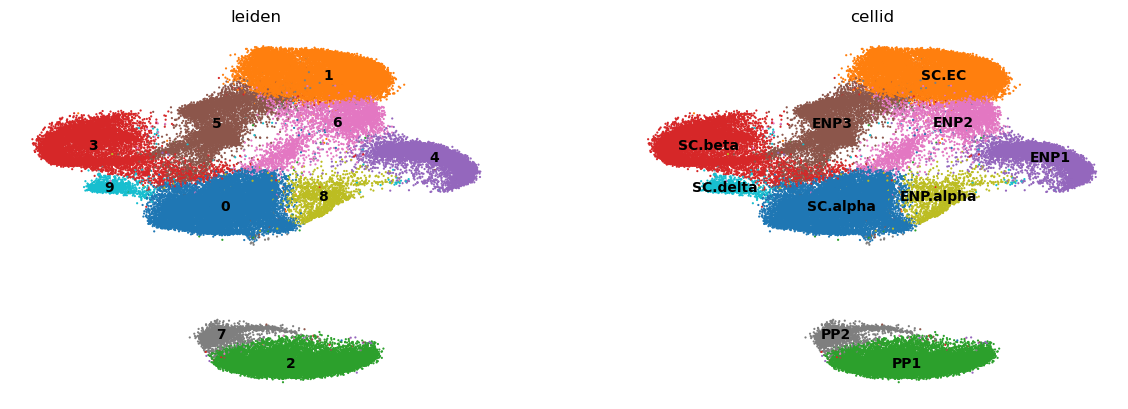

In [41]:
# Plot the umap
sc.pl.umap(adata_prev, color=["leiden", "cellid"], frameon=False, s=10, show=False, legend_loc="on data")

In [42]:
# Cross tab cellid with donor
pd.crosstab(adata_prev.obs["cellid"], adata_prev.obs["donor"])

donor,MM129,MM157,MM166,MM168,MM290
cellid,,,,,
SC.alpha,68,7799,3231,2118,186
SC.EC,58,8687,2688,1693,107
PP1,9739,106,14,13,236
SC.beta,76,5632,1549,923,102
ENP1,5440,39,1,6,622
ENP3,91,4508,771,585,115
ENP2,117,1055,372,175,1384
PP2,126,506,14,14,1620
ENP.alpha,193,144,3,2,1151


In [43]:
# Get the cluster proportions across samples
cross_tab = pd.crosstab(adata_prev.obs["donor"], adata_prev.obs["cellid"])
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab_norm

cellid,SC.alpha,SC.EC,PP1,SC.beta,ENP1,ENP3,ENP2,PP2,ENP.alpha,SC.delta
donor,,,,,,,,,,
MM129,0.004269,0.003641,0.611362,0.004771,0.341494,0.005712,0.007345,0.007910,0.012116,0.001381
MM157,0.266742,0.297113,0.003625,0.192626,0.001334,0.154183,0.036083,0.017306,0.004925,0.026062
MM166,0.363442,0.302362,0.001575,0.174241,0.000112,0.086727,0.041845,0.001575,0.000337,0.027784
MM168,0.376935,0.301299,0.002314,0.164264,0.001068,0.104111,0.031144,0.002492,0.000356,0.016017
MM290,0.033345,0.019183,0.042309,0.018286,0.111510,0.020617,0.248118,0.290427,0.206346,0.009860


<Axes: xlabel='donor'>

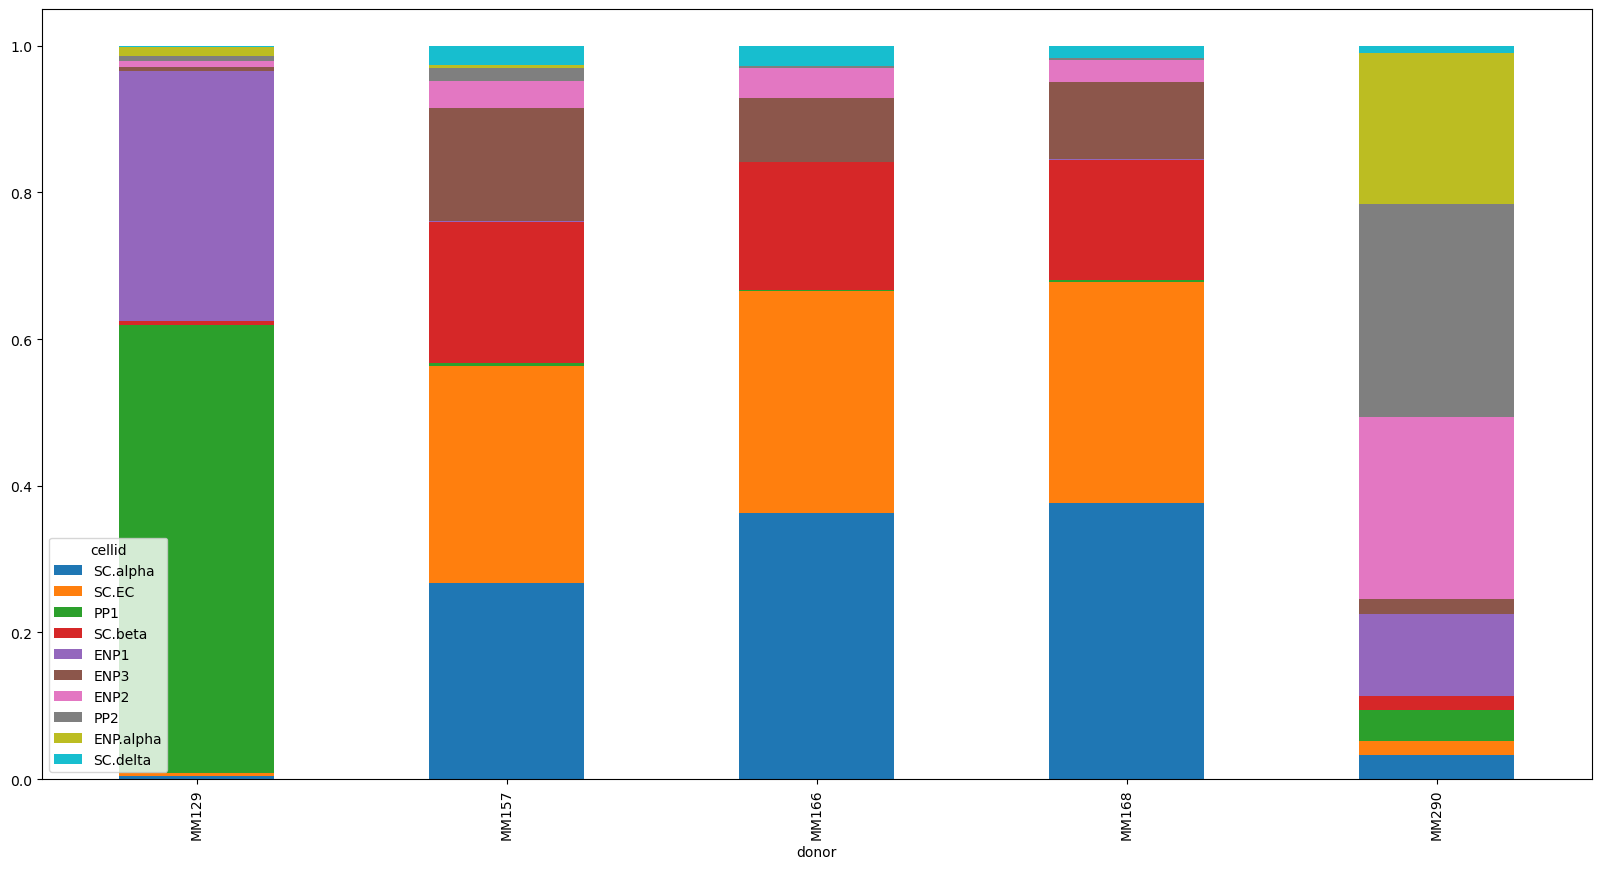

In [44]:
# Make a pretty bar plot with x-axis showing sample and y-axis showing manual_cellid_annotation
cross_tab_norm.plot.bar(stacked=True, figsize=(20, 10))

In [45]:
# Grab these for later
cellids_in_prev = cross_tab.columns

# See if the clusters I've identified match up

In [48]:
# Variables 
cellid_map = adata_prev.obs["cellid"]
outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe"
#outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/26Oct23/cellcommander"

In [49]:
# Read in samples
adata_list = []
samples = []
sample_cellid_proportions = pd.DataFrame(columns=cellids_in_prev)
for h5ad_path in h5ad_paths:
    #sample = h5ad_path.split("/")[-3]
    sample = h5ad_path.split("/")[-2]
    print(f"Reading in {sample}")
    adata = sc.read_h5ad(h5ad_path)
    adata.obs.index = sample + "_" + adata.obs.index
    adata.obs.index = adata.obs.index.str.replace("-1", "")  # Needed this for this case
    adata.obs["cellid"] = adata.obs.index.map(cellid_map).astype("category")
    #adata.obsm["X_umap"] = adata.obsm["X_lsi_umap"].copy()

        # Drop all cells with cellids that that are NaN or have less than 10 cells
    na_mask = adata.obs["cellid"].isna()
    num_nas = na_mask.sum()
    print(f"Number of cells with NaN cellids: {num_nas}")
    adata = adata[~na_mask, :]
    cellid_counts = adata.obs["cellid"].value_counts()
    low_cellids = cellid_counts[cellid_counts < 10].index
    low_cellid_mask = adata.obs["cellid"].isin(low_cellids)
    num_low_cellids = low_cellid_mask.sum()
    print(f"Number of cells with low cellids: {num_low_cellids}")
    adata = adata[~low_cellid_mask, :]

    # Make a dir to save
    curr_outdir_path = os.path.join(outdir_path, sample, "annotate", "publication")
    if not os.path.exists(curr_outdir_path):
        os.makedirs(curr_outdir_path)

    # Plot the UMAP for that sample
    print("Plotting UMAP")
    adata.obs.index = adata.obs.index.str.replace(sample + "_", "")
    with plt.rc_context({"axes.facecolor": "white", "figure.facecolor": "white"}):
        sc.pl.umap(adata, color=["leiden_1", "cellid"], frameon=False, show=False)
        #sc.pl.umap(adata, color=["initial_leiden_1", "cellid"], frameon=False, show=False)
        plt.savefig(os.path.join(curr_outdir_path, "publication_mapped_cellid_umap.png"), dpi=300, bbox_inches="tight")
        plt.close()
    
    # Add the proportions of each cellid
    cellid_proportions = adata.obs["cellid"].value_counts().div(adata.shape[0])
    cellid_proportions.name = sample
    sample_cellid_proportions = sample_cellid_proportions.append(cellid_proportions)
    
    # Save
    print("Saving")
    adata.write(os.path.join(curr_outdir_path, "annotated.h5ad"))

Reading in MM129


Number of cells with NaN cellids: 5971
Number of cells with low cellids: 0
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_1177228/1544795013.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_cellid_proportions = sample_cellid_proportions.append(cellid_proportion

Saving
Reading in MM157
Number of cells with NaN cellids: 7731
Number of cells with low cellids: 0
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_1177228/1544795013.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_cellid_proportions = sample_cellid_proportions.append(cellid_proportion

Saving
Reading in MM166
Number of cells with NaN cellids: 1315
Number of cells with low cellids: 11
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_1177228/1544795013.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_cellid_proportions = sample_cellid_proportions.append(cellid_proportion

Saving
Reading in MM168
Number of cells with NaN cellids: 1813
Number of cells with low cellids: 12
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_1177228/1544795013.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_cellid_proportions = sample_cellid_proportions.append(cellid_proportion

Saving
Reading in MM290
Number of cells with NaN cellids: 2250
Number of cells with low cellids: 0
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_1177228/1544795013.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_cellid_proportions = sample_cellid_proportions.append(cellid_proportion

Saving


<Axes: >

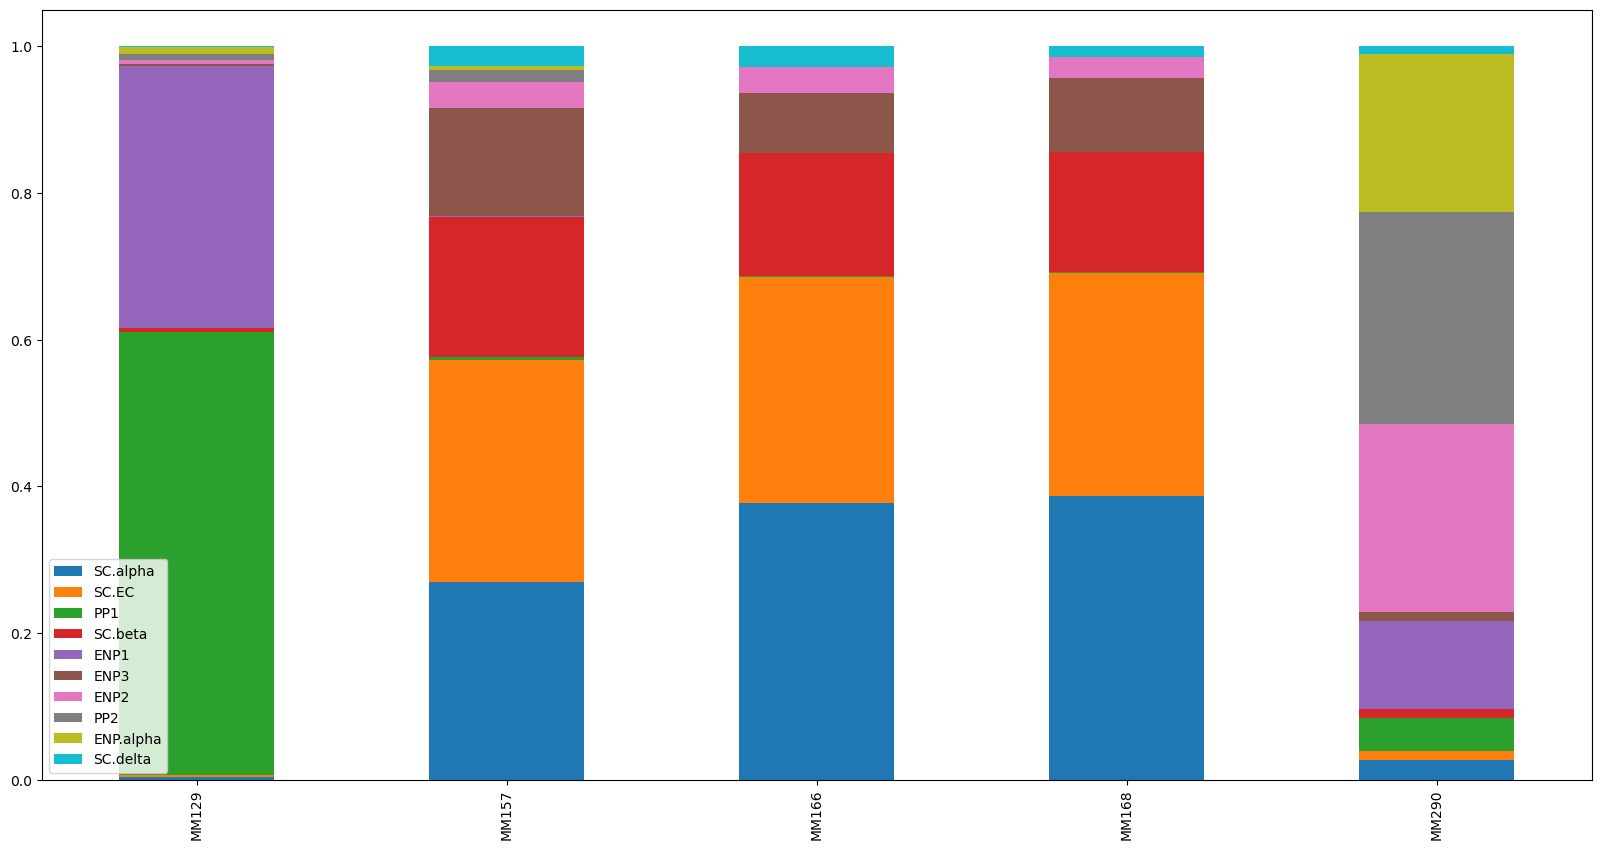

In [50]:
# Make a pretty bar plot with x-axis showing sample and y-axis showing manual_cellid_annotation
sample_cellid_proportions.plot.bar(stacked=True, figsize=(20, 10))

# DONE!

---